In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import integrate

import OpenAEM

In [2]:
def biot_savart(rod: OpenAEM.DLS, xv: np.ndarray):
    xpv = rod.points()
        
    sv = xv[:, :, np.newaxis] - xpv[:, np.newaxis, :]
    s  = np.linalg.norm(sv, axis=0)[np.newaxis, :, :]
        
    xpvd = rod.dirs()[:, np.newaxis, :]
        
    # parameter of rod curve
    t = rod.get_t()
    uv = -0.5*integrate.simps(np.cross(sv, xpvd, axis=0)/s**3, t)
    
    return uv

def induced_velocity(eddy: list[OpenAEM.DLS], xv: np.ndarray, r0=0.1):
    uv = np.zeros_like(xv)
    for rod in eddy:
        s = rod.distance2pts(xv)
        uv[:, s > r0] += biot_savart(rod, xv[:, s > r0])
        
    return uv

## Setup the eddy

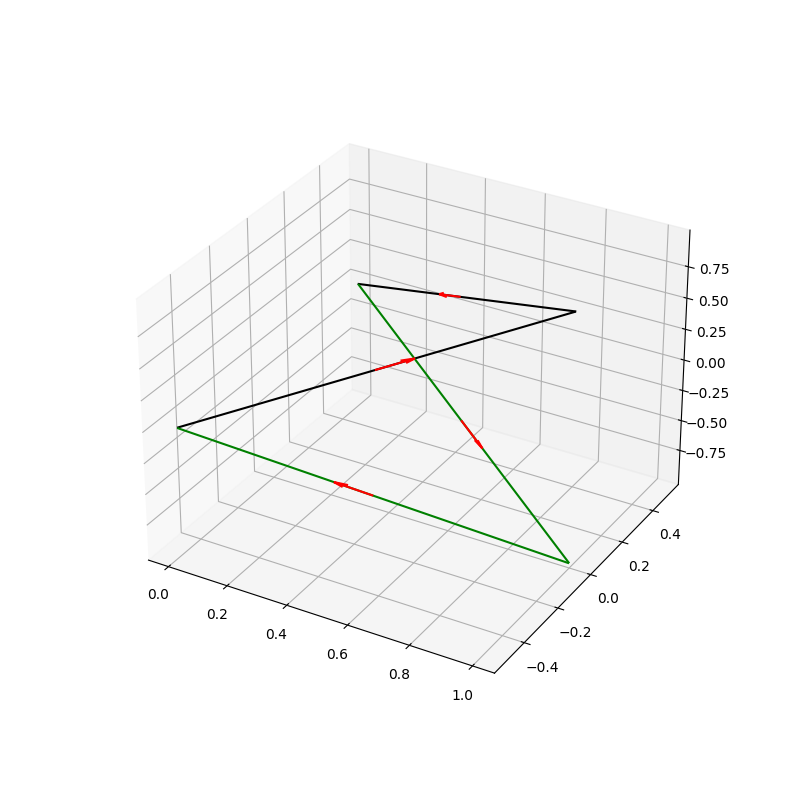

In [3]:
p0 = np.array([0.0, -0.5, 0.0])
p1 = np.array([1.0,  0.0, 1.0])
p2 = np.array([0.0,  0.5, 0.0])
left_leg  = OpenAEM.DLS(p0, p1)
right_leg = OpenAEM.DLS(p1, p2)
eddy = [left_leg, right_leg]

mirror_eddy = OpenAEM.mirror_eddy(eddy)

attached_eddy = eddy + mirror_eddy

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
OpenAEM.plot_eddy(eddy, ax)
OpenAEM.plot_eddy(mirror_eddy, ax, color='green')

## Domain of influence

In [4]:
nx = 54
ny = 54
nz = 54
x = np.linspace(-40, 40, nx)
y = np.linspace(-40, 40, ny)
z = np.linspace( 0, 40, nz)

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
xv = np.array([X.ravel(), Y.ravel(), Z.ravel()])
uv = induced_velocity(attached_eddy, xv)

In [5]:
U = uv[0, :].reshape(nx, ny, nz)
V = uv[1, :].reshape(nx, ny, nz)
W = uv[2, :].reshape(nx, ny, nz)
Umag = np.sqrt(U**2 + V**2 + W**2)

Text(0, 0.5, '$log(\\frac{|\\mathbf{U}|}{u_0})$')

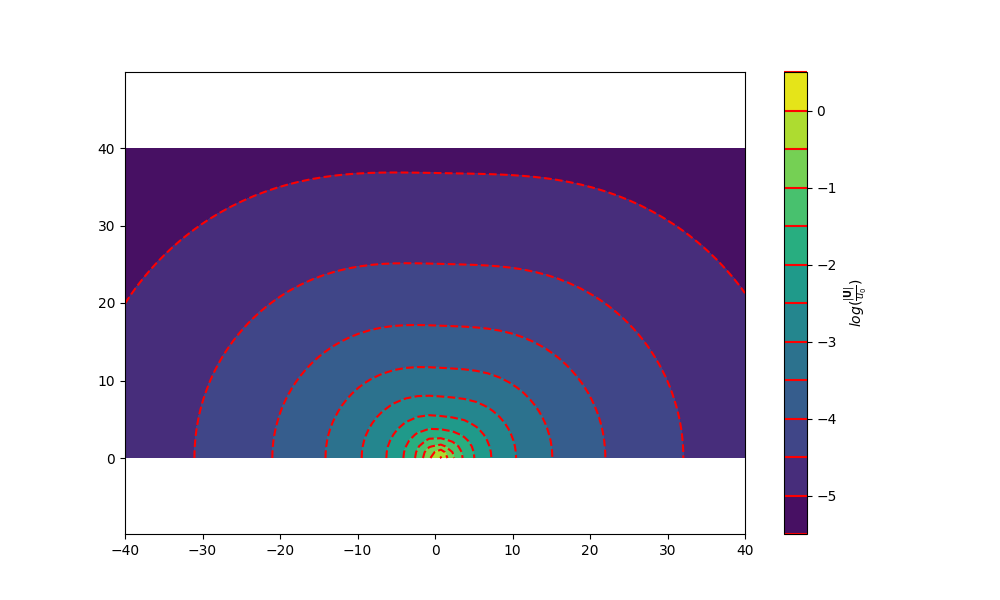

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.axis('equal')
CS = ax.contourf(X[:, ny//2, :], Z[:, ny//2, :], np.log10(Umag[:, ny//2, :]), 10)
CS2 = ax.contour(CS, levels=CS.levels, colors='r')
cbar = fig.colorbar(CS)
cbar.add_lines(CS2)
cbar.ax.set_ylabel(r'$log(\frac{|\mathbf{U}|}{u_0})$')

## Eddy intensity function

In [11]:
nx = 501
ny = 501
nz = 51
x = np.linspace(-5, 5, nx)
y = np.linspace(-5, 5, ny)
z = np.linspace( 0, 1, nz)

U = np.zeros((nx, ny, nz))
V = np.zeros_like(U)
W = np.zeros_like(U)

for i in range(nx):
    if i % 10 == 0:
        print(i)
    X, Y, Z = np.meshgrid(x[i], y, z, indexing='ij')
    xv = np.array([X.ravel(), Y.ravel(), Z.ravel()])
    uv = induced_velocity(attached_eddy, xv)
    
    U[i, :, :] = uv[0, :].reshape(ny, nz)
    V[i, :, :] = uv[1, :].reshape(ny, nz)
    W[i, :, :] = uv[2, :].reshape(ny, nz)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500


In [12]:
I13 = np.mean(U*W, axis=(0, 1))

I11 = np.mean(U*U, axis=(0, 1))
I22 = np.mean(V*V, axis=(0, 1))

I33 = np.mean(W*W, axis=(0, 1))

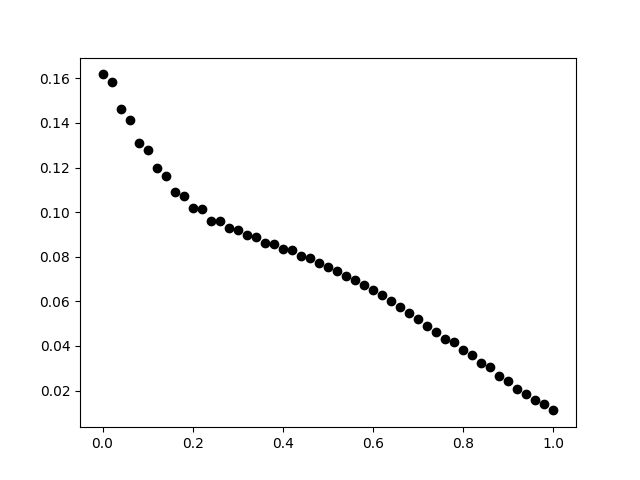

In [17]:
plt.figure()
plt.plot(z, I22, 'ko')